# EMBER Characterizations Notebook

This notebook contains all the methods for visualizing EMBER measurement data.

## Import libraries

External libraries: `matplotlib`, `numpy`, `scipy`, `pandas`.

In [3]:
# Import internal libraries
import json

# Import custom libraries
import ppf
from ppf import PPFScale

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Pick VDDIO (VDDLS) to study

Most experiments operate at some particular VDDLS value. Set that here.

In [4]:
# Set VDDIO (times 10)
vddio = 33

## RRAM FORM statistics

Here, we plot the distribution of WL DAC levels needed to induce FORMing (at VDDLS=3.3V). Then we plot the distribution of the resultant final conductance values after FORMing.

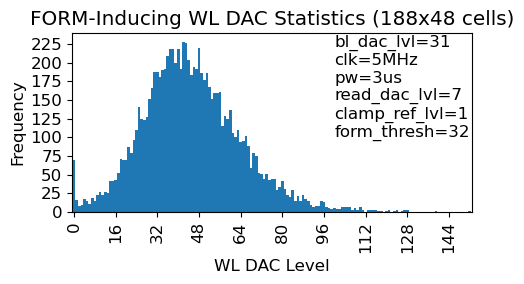

In [5]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do", "ignore"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure for FORM-inducing WL DAC level statistics
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 100, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

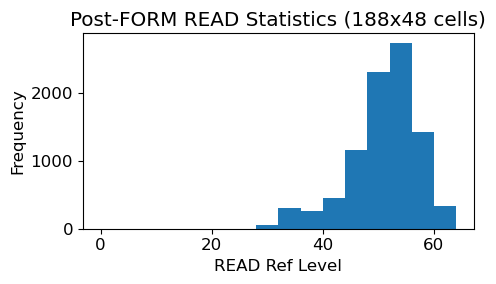

In [6]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure for post-FORM READ statistics
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

## Checkerboard demo

Here, we plot programmed checkerboard patterns to demonstrate 1-4bpc programmability. We also indicate the Gray code BER and linear root mean squared error (RMSE) of the measured values from the programmed values.

[[1152    0]
 [   0 1152]]
[[576   0   0   0]
 [  0 576   0   0]
 [  0   0 576   0]
 [  0   0   0 576]]
[[288   0   0   0   0   0   0   0]
 [  1 284   3   0   0   0   0   0]
 [  0   1 287   0   0   0   0   0]
 [  0   0   1 286   1   0   0   0]
 [  0   0   0   0 288   0   0   0]
 [  0   0   0   0   0 288   0   0]
 [  0   0   0   0   0   0 288   0]
 [  0   0   0   0   0   0   0 288]]
[[143   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 17 102  25   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3  11 118  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  21 101  20   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3  13 117  11   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   6 122  16   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   7 124  13   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5 121  18   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   6 116  22   0   0   0   0   0   0]
 [  0   0   

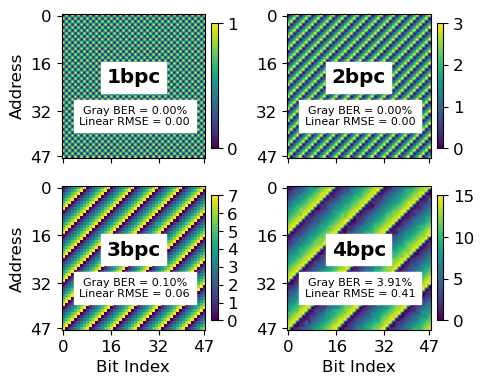

In [7]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear RMSE = " + format(rmse, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

  # Set ticks
  plt.xticks([0,16,32,47])
  plt.yticks([0,16,32,47])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig("figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

## Conductance level visualization

Here, we plot the READ/WRITE level boundaries.

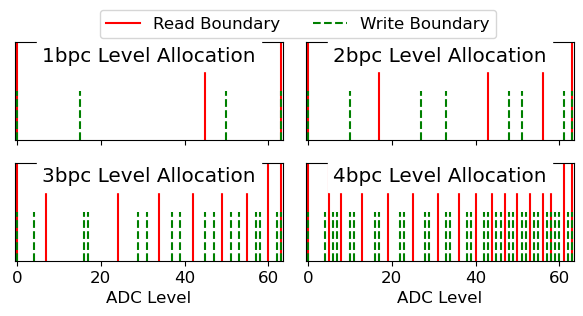

In [8]:
# Plot conductance ranges
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(6,3))
for bpc in range(1, 5):
    # Subplot
    plt.subplot(220 + bpc)
    
    # Load settings
    settings = json.load(open(f"../settings/{bpc}bpc.json"))
    
    # Plot
    plt.axvline(0, 0, 1, color='r', label="Read Boundary" if bpc == 1 else None)
    for level in settings["level_settings"]:
        plt.axvline(level["adc_upper_read_ref_lvl"], 0, 1, color='r')
        plt.axvline(level["adc_lower_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
        plt.axvline(level["adc_upper_write_ref_lvl"], 0, 0.5, color='g', linestyle='--', label="Write Boundary" if bpc == 1 and level["adc_upper_write_ref_lvl"] == 63 else None)
    plt.xlim(-0.5, 63.5)
    plt.gca().get_yaxis().set_visible(False)
    plt.title(f"{bpc}bpc Level Allocation", backgroundcolor="white", y=1, pad=-14)
    if bpc > 2:
        plt.xlabel("ADC Level")
lgd = fig.legend(loc="center", bbox_to_anchor=(0.51, 1), ncol=2)
plt.tight_layout()
plt.savefig("figs/levels.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")
plt.show()

## Endurance

Here, we show so endurance cycling data caused by SET/RESET loops (without verify), with READs performed intermittently.

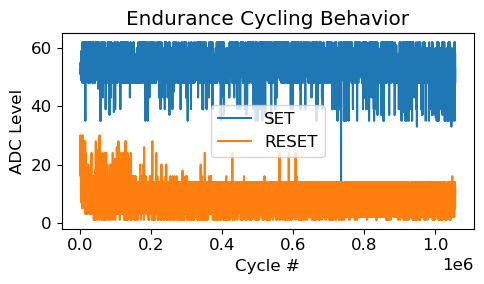

In [9]:
# Load endurance and show an example
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

## Retention data
Here, we show the sigma vs. mu for conductance level allocation, and also plot the conductance distributions of each programmed level at time `t`. 

In [10]:
# Load retention time data
tdata = pd.read_csv("../data/retention2.min.csv.gz")
tdata

Unnamed: 0  addr          time  lvl  lvli   i  tmin  tmax    timept
0                0  1024      0.000000    6     6   0     4     8       0.0
1                1  1024      0.000000    8     6   1     4     8       0.0
2                2  1024      0.000000    7     6   2     4     8       0.0
3                3  1024      0.000000    5     6   3     4     8       0.0
4                4  1024      0.000000    6     6   4     4     8       0.0
...            ...   ...           ...  ...   ...  ..   ...   ...       ...
113627    62790555  1977  80014.943718   56    58  11    57    61  100000.0
113628    62790556  1977  80014.943718   59    58  12    57    61  100000.0
113629    62790557  1977  80014.943718   58    58  13    57    61  100000.0
113630    62790558  1977  80014.943718   59    58  14    57    61  100000.0
113631    62790559  1977  80014.943718   60    58  15    57    61  100000.0

[113632 rows x 9 columns]

           3             2
3.309e-06 x - 0.0005725 x + 0.01349 x + 1.526
           3            2
2.983e-05 x - 0.003451 x + 0.09626 x + 1.252
           3            2
6.432e-05 x - 0.007314 x + 0.2138 x + 0.7494
           3           2
9.461e-05 x - 0.01069 x + 0.3127 x + 0.3524
           3           2
0.0001272 x - 0.01443 x + 0.4299 x - 0.1005
           3           2
0.0001471 x - 0.01675 x + 0.5016 x - 0.3244
           3           2
0.0001606 x - 0.01825 x + 0.5471 x - 0.5029
           3           2
0.0001763 x - 0.02029 x + 0.6197 x - 0.9493


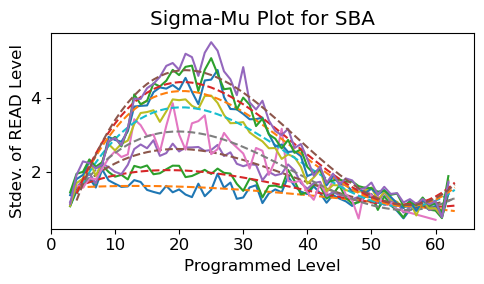

In [11]:
# Plot sigma-mu
%matplotlib inline
times = [0, 0.1, 1, 10, 100, 1000, 10000, 100000]
for time in times:
    sbadata = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))].groupby("lvli")["lvl"].std()
    sbadata.plot(label=f"data,t={time}")
    fit = np.polyfit(sbadata.index.values, sbadata.values, 3)
    print(np.poly1d(fit))
    plt.plot(range(4,64), np.poly1d(fit)(range(4,64)), '--', label=f"fit,t={time}")
plt.title("Sigma-Mu Plot for SBA")
plt.xlabel("Programmed Level")
plt.ylabel("Stdev. of READ Level")
# plt.legend()
plt.tight_layout()
plt.savefig("figs/sigmamu.pdf")
plt.show()

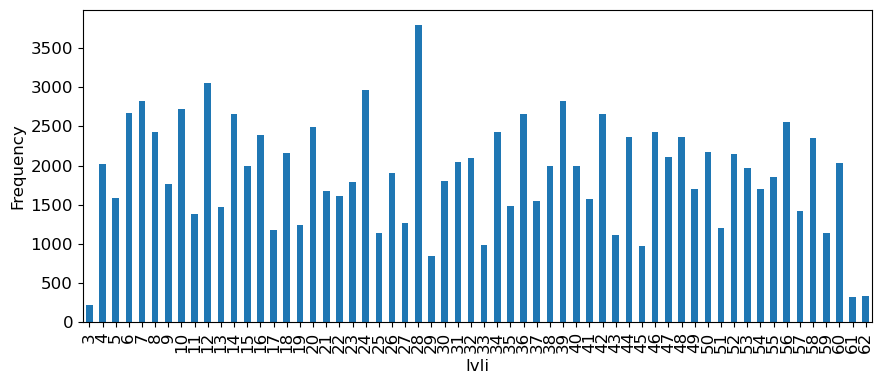

In [12]:
# Plot frequency of each level to check
plt.rcParams["figure.figsize"] = [9, 4]
tdata.groupby("lvli").count()["lvl"].plot.bar()
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

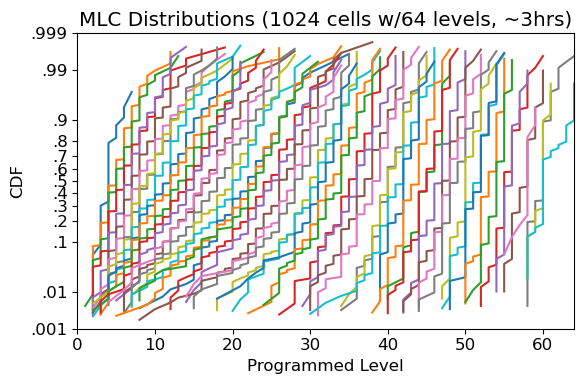

In [27]:
# Show distribution
time = 100
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/64 levels, ~3hrs)")
d = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))]
for i in range(64):
# for i in [15, 37, 52, 62]:
# for i in [19, 50]:
    rdata = d[d["lvli"] == i]
    if len(rdata) != 0:
        plt.plot(sorted(rdata["lvl"].values), np.linspace(0+1/len(rdata), 1-1/len(rdata), len(rdata)), label=i)
plt.xlabel("Programmed Level")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 64)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.savefig("figs/mlcdist.pdf")
plt.show()

## SET/RESET final conductance sweeps

We test the effect of pulses with different {VWL, VBL, pw, gi} combos on final conductance gf.

### SET sweep

In [14]:
# SET sweep data
setdata = pd.read_csv(f"../data/setsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
setdata

addr             t  vwl  vbl  pw  gi  gf
0       35887  1.685655e+09    0    0   1   8   8
1        6153  1.685655e+09    0    4   1   6  36
2       48880  1.685655e+09    0    8   1  10  43
3        9017  1.685655e+09    0   12   1  15  58
4       57814  1.685655e+09    0   16   1   7  49
...       ...           ...  ...  ...  ..  ..  ..
257820  60529  1.685767e+09   34   12   2  19  43
257821  36999  1.685767e+09   34   16   2   9  50
257822  37637  1.685767e+09   34   20   2   8  57
257823  15529  1.685767e+09   34   24   2  10  59
257824   7718  1.685767e+09   34   28   2  12  64

[4125200 rows x 7 columns]

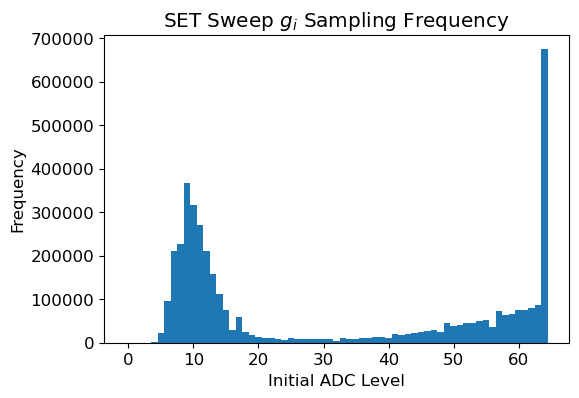

In [15]:
# SET sweep gi sampling frequency check
setdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("SET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

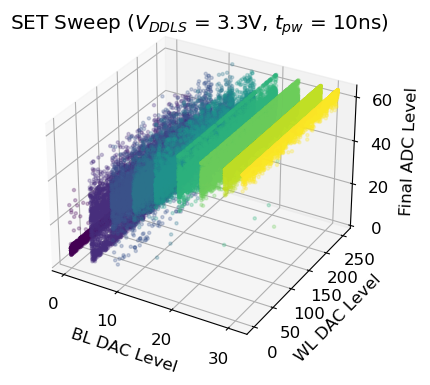

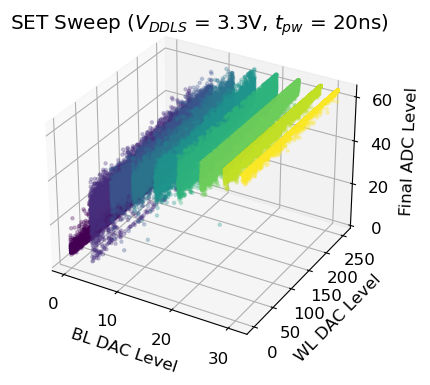

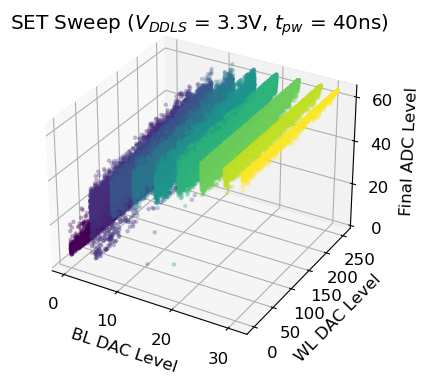

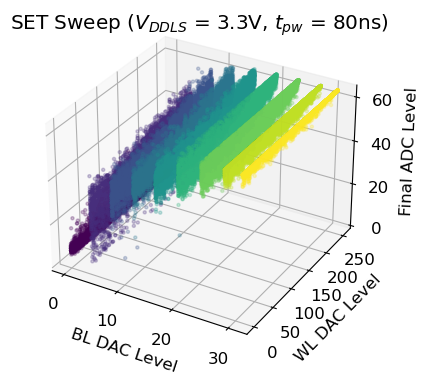

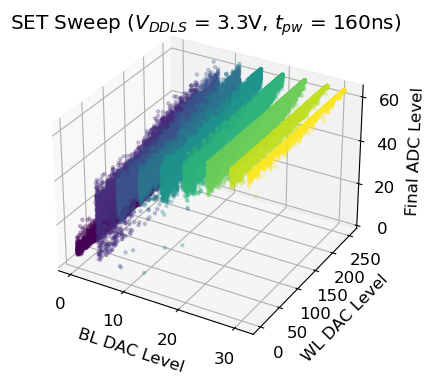

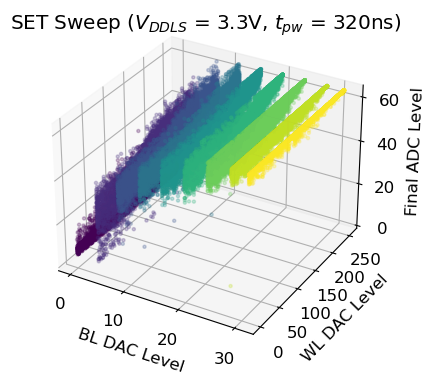

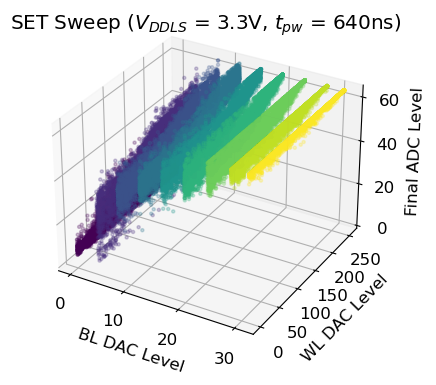

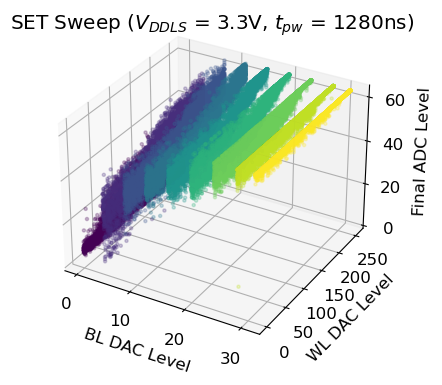

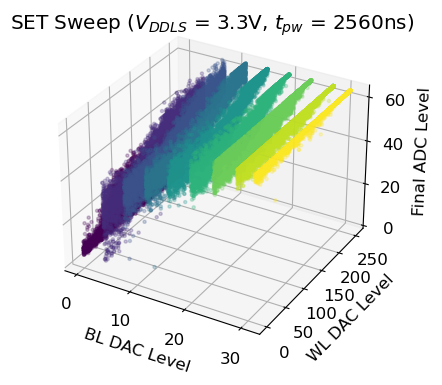

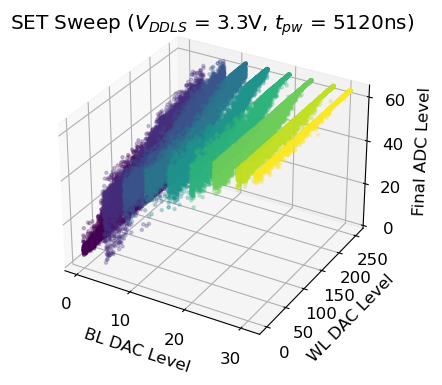

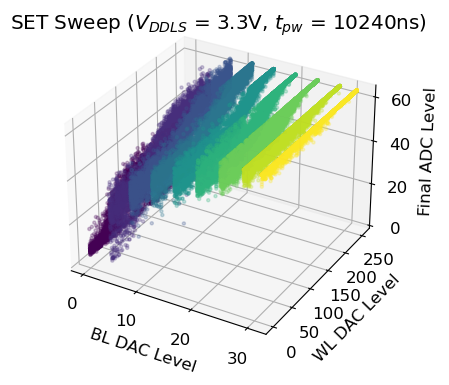

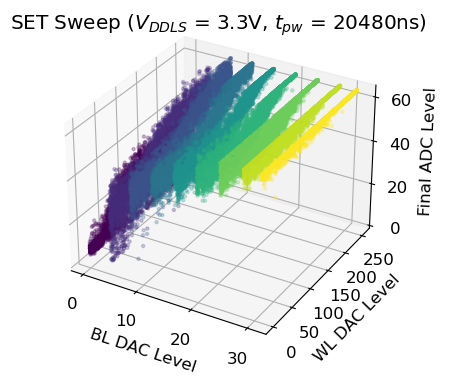

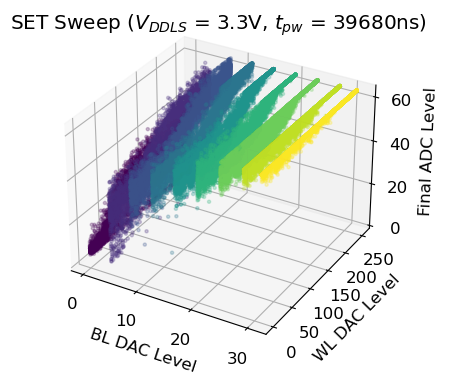

In [16]:
# Plot SET sweep
for pw in setdata["pw"].unique():
    d = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)][["vwl","vbl","pw","gf"]]
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = {pw*10}ns)", y=1)
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
#     ax.view_init(elev=7, azim=-26)
    ax.scatter3D(d['vbl'], d['vwl'], d['gf'], c=d['vbl'], marker='.', alpha=0.25)
    plt.savefig(f"figs/set_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

### RESET sweep

In [17]:
# RESET sweep data
resetdata = pd.read_csv(f"../data/resetsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
resetdata

addr             t  vwl  vsl  pw  gi  gf
0       11143  1.685598e+09    0    0   1  50  49
1       29218  1.685598e+09    0    4   1  46  46
2       62070  1.685598e+09    0    8   1  37  41
3       47766  1.685598e+09    0   12   1   3   6
4       13916  1.685598e+09    0   16   1  10  11
...       ...           ...  ...  ...  ..  ..  ..
263629  40100  1.685664e+09  226    8  16  47  47
263630   9371  1.685664e+09  226   12  16  38  25
263631   8726  1.685664e+09  226   16  16  62  62
263632  30210  1.685664e+09  226   20  16  64  64
263633   2101  1.685664e+09  226   24  16  45  14

[4218144 rows x 7 columns]

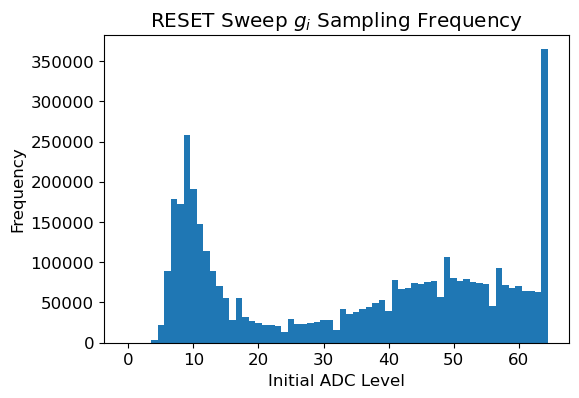

In [18]:
# RESET sweep gi sampling frequency check
plt.figure()
resetdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("RESET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

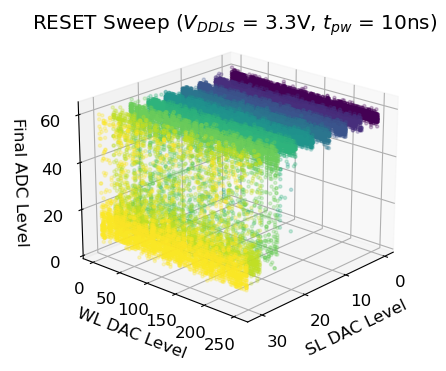

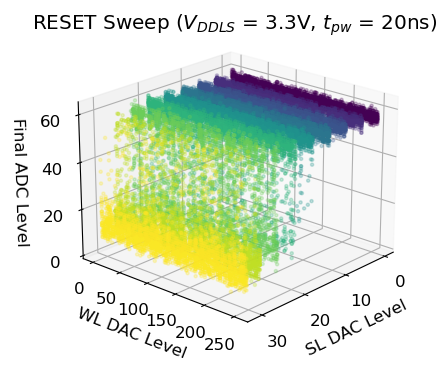

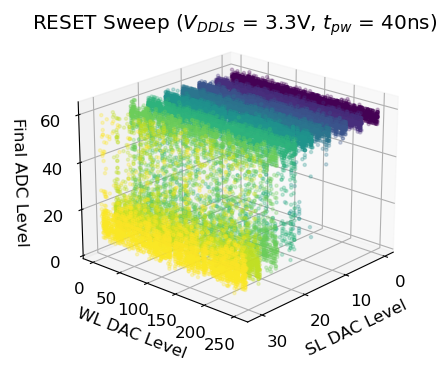

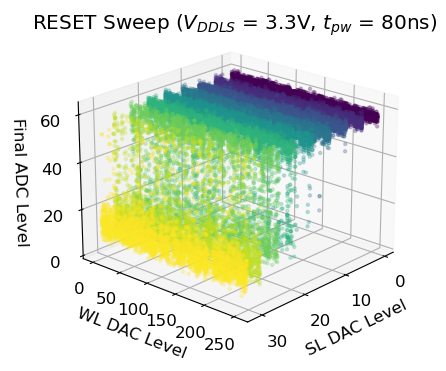

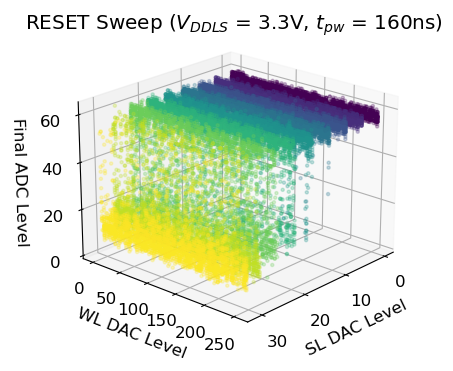

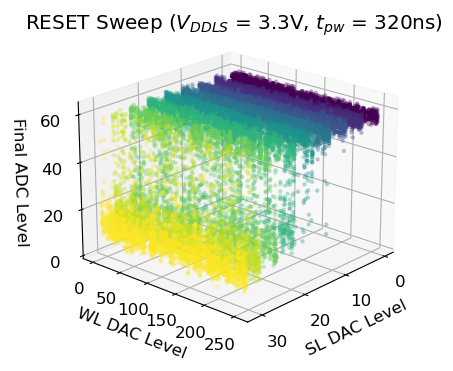

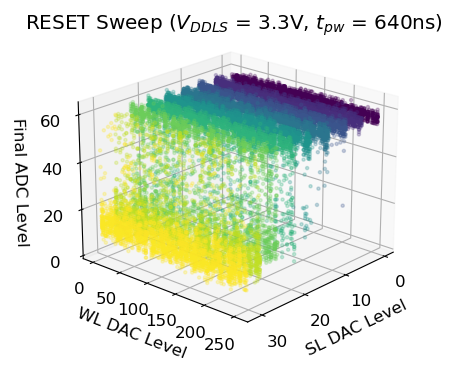

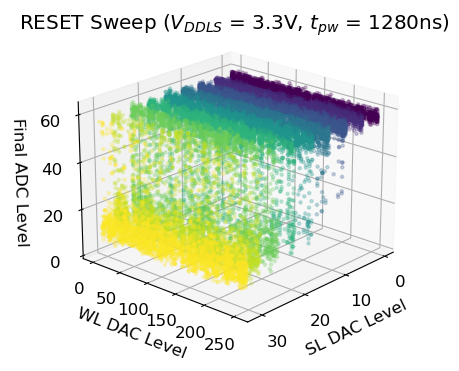

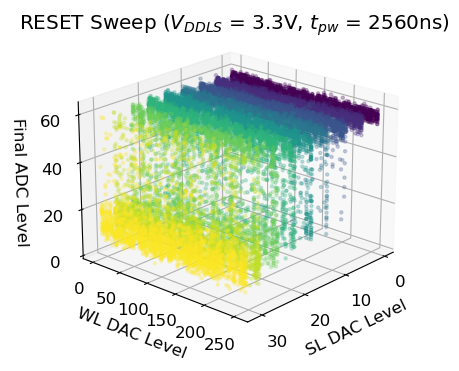

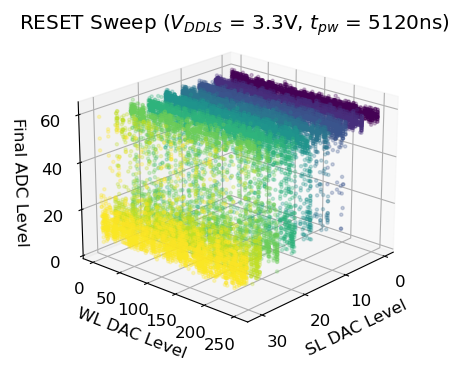

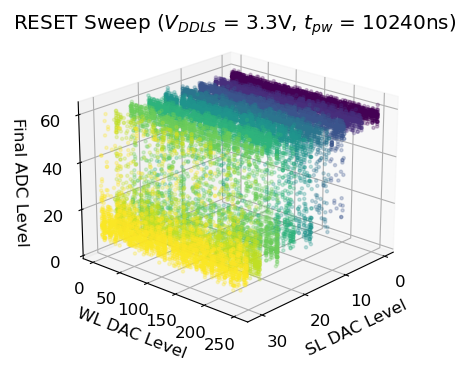

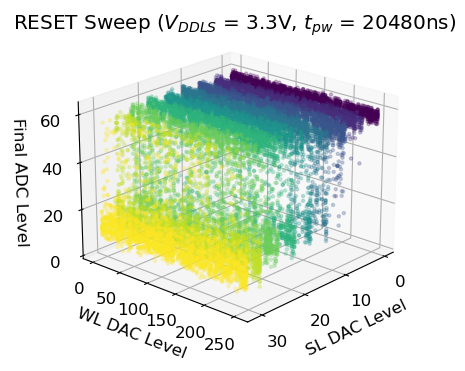

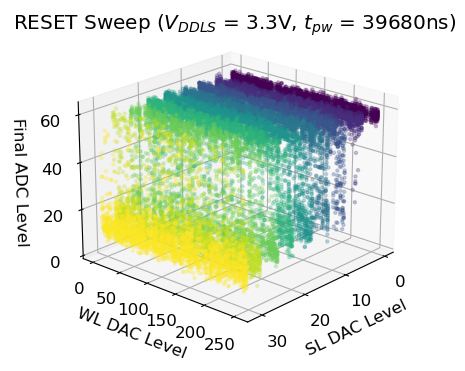

In [19]:
# Plot RESET sweep
for pw in resetdata["pw"].unique():
    d = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)][["vwl","vsl","pw","gf"]]
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = {pw*10}ns)", y=1)
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.scatter3D(d['vsl'], d['vwl'], d['gf'], c=d['vsl'], marker='.', alpha=0.25)
    plt.savefig(f"figs/reset_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

## SET/RESET Power

In this section, we measure SET/RESET power across different pulse conditions.

### SET Pulse Power

In [20]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/setpower{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vbl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

time  vwl  vbl    pw    i(vdd)  i(vdd_dac)    i(vsa)  i(vddio)  \
0    1.686634e+09    0    0  3968  0.000090    0.000092  0.000090  0.001058   
1    1.686634e+09    0    4  3968  0.000090    0.000091  0.000090  0.001060   
2    1.686634e+09    0    8  3968  0.000090    0.000092  0.000090  0.001078   
3    1.686634e+09    0   12  3968  0.000089    0.000091  0.000090  0.001053   
4    1.686634e+09    0   16  3968  0.000090    0.000091  0.000090  0.001084   
..            ...  ...  ...   ...       ...         ...       ...       ...   
148  1.686644e+09  255   16  3968  0.000090    0.000091  0.000062  0.001851   
149  1.686644e+09  255   20  3968  0.000090    0.000091  0.000062  0.001912   
150  1.686644e+09  255   24  3968  0.000090    0.000091  0.000062  0.001949   
151  1.686644e+09  255   28  3968  0.000076    0.000080  0.000062  0.001985   
152  1.686644e+09  255   31  3968  0.000090    0.000091  0.000062  0.002032   

     i(vddio_dac)  v(vddio)  ...  v(vdd)  v(vdd_dac)  v(vsa)    p(vdd)  \
0        0.000389   3.29994  ...     0.9         0.9     0.9  0.000081   
1        0.000389   3.29994  ...     0.9         0.9     0.9  0.000081   
2        0.000388   3.29994  ...     0.9         0.9     0.9  0.000081   
3        0.000389   3.29994  ...     0.9         0.9     0.9  0.000081   
4        0.000389   3.29994  ...     0.9         0.9     0.9  0.000081   
..            ...       ...  ...     ...         ...     ...       ...   
148      0.000376   3.30005  ...     0.9         0.9     0.9  0.000081   
149      0.000378   3.30005  ...     0.9         0.9     0.9  0.000081   
150      0.000379   3.30005  ...     0.9         0.9     0.9  0.000081   
151      0.000379   3.30005  ...     0.9         0.9     0.9  0.000069   
152      0.000380   3.30005  ...     0.9         0.9     0.9  0.000081   

     p(vdd_dac)    p(vsa)  p(vddio)  p(vddio_dac)    totpow  n  
0      0.000083  0.000081  0.003492      0.001283  0.005021  0  
1      0.000082  0.000081  0.003499      0.001286  0.005028  0  
2      0.000082  0.000081  0.003556      0.001282  0.005082  0  
3      0.000082  0.000081  0.003475      0.001283  0.005001  0  
4      0.000082  0.000081  0.003577      0.001283  0.005104  0  
..          ...       ...       ...           ...       ... ..  
148    0.000082  0.000056  0.006107      0.001242  0.007568  2  
149    0.000082  0.000056  0.006309      0.001248  0.007776  2  
150    0.000082  0.000056  0.006431      0.001251  0.007900  2  
151    0.000072  0.000056  0.006552      0.001252  0.008001  2  
152    0.000082  0.000056  0.006705      0.001256  0.008179  2  

[459 rows x 21 columns]

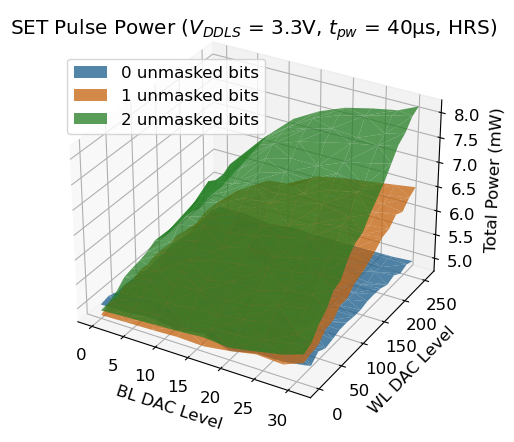

In [21]:
# 3-D plot of pulse power vs. {VWL, VBL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"SET Pulse Power ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, HRS)", y=1)
ax.set_xlabel("BL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vbl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/setpower{vddio}.pdf")
plt.show()

### RESET Pulse Power

In [22]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/resetpower{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vsl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

time  vwl  vsl    pw    i(vdd)  i(vdd_dac)    i(vsa)  i(vddio)  \
0   1.686681e+09    0    0  3968  0.000090    0.000092  0.000090  0.001072   
1   1.686681e+09    0    4  3968  0.000090    0.000092  0.000090  0.001077   
2   1.686681e+09    0    8  3968  0.000090    0.000092  0.000090  0.001082   
3   1.686681e+09    0   12  3968  0.000090    0.000091  0.000090  0.001085   
4   1.686681e+09    0   16  3968  0.000089    0.000091  0.000090  0.001063   
..           ...  ...  ...   ...       ...         ...       ...       ...   
89  1.686686e+09  255   16  3968  0.000090    0.000091  0.000062  0.001870   
90  1.686686e+09  255   20  3968  0.000002    0.000074  0.000062  0.001914   
91  1.686686e+09  255   24  3968  0.000090    0.000091  0.000062  0.001973   
92  1.686686e+09  255   28  3968  0.000090    0.000092  0.000062  0.001993   
93  1.686686e+09  255   31  3968  0.000090    0.000091  0.000062  0.002044   

    i(vddio_dac)  v(vddio)  ...  v(vdd)  v(vdd_dac)  v(vsa)    p(vdd)  \
0       0.000389   3.30001  ...     0.9         0.9     0.9  0.000081   
1       0.000389   3.30001  ...     0.9         0.9     0.9  0.000081   
2       0.000390   3.30001  ...     0.9         0.9     0.9  0.000081   
3       0.000390   3.30001  ...     0.9         0.9     0.9  0.000081   
4       0.000389   3.30001  ...     0.9         0.9     0.9  0.000081   
..           ...       ...  ...     ...         ...     ...       ...   
89      0.000378   3.30003  ...     0.9         0.9     0.9  0.000081   
90      0.000380   3.30003  ...     0.9         0.9     0.9  0.000001   
91      0.000380   3.30003  ...     0.9         0.9     0.9  0.000081   
92      0.000382   3.30003  ...     0.9         0.9     0.9  0.000081   
93      0.000384   3.30003  ...     0.9         0.9     0.9  0.000081   

    p(vdd_dac)    p(vsa)  p(vddio)  p(vddio_dac)    totpow  n  
0     0.000083  0.000081  0.003536      0.001285  0.005066  0  
1     0.000082  0.000081  0.003555      0.001285  0.005085  0  
2     0.000083  0.000081  0.003570      0.001286  0.005100  0  
3     0.000082  0.000081  0.003582      0.001288  0.005113  0  
4     0.000082  0.000081  0.003509      0.001285  0.005037  0  
..         ...       ...       ...           ...       ... ..  
89    0.000082  0.000056  0.006171      0.001247  0.007636  2  
90    0.000067  0.000056  0.006315      0.001254  0.007692  2  
91    0.000082  0.000056  0.006512      0.001253  0.007985  2  
92    0.000082  0.000056  0.006576      0.001261  0.008055  2  
93    0.000082  0.000056  0.006746      0.001266  0.008231  2  

[256 rows x 21 columns]

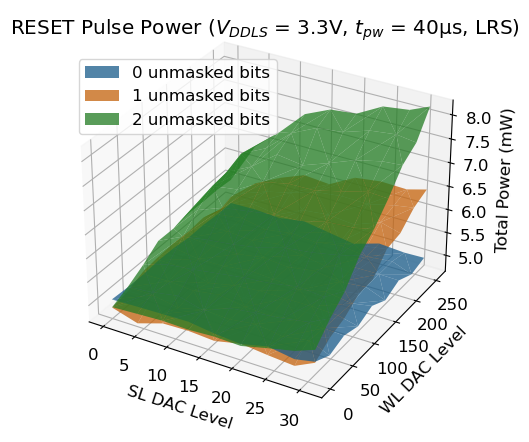

In [23]:
# 3-D plot of pulse power vs. {VWL, VSL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"RESET Pulse Power ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, LRS)", y=1)
ax.set_xlabel("SL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vsl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/resetpower{vddio}.pdf")
plt.show()